# Eval scripts

In [1]:
%cd ..

/home/ekremezm/CounterfakeWorkspace/dino


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import ImageFile
from torchvision import datasets
from torchvision import transforms 
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE

import vision_transformer as vits 

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Model Load

In [3]:
dict_path      = "results/all_in_moda_test_v0.1/checkpoint.pth"
arch           = "vit_tiny"
checkpoint_key = "student"
patch_size     = 16

device = "cuda" if torch.cuda.is_available() else 'cpu'

In [4]:
backbone_model = vits.__dict__[arch](patch_size = patch_size, num_classes = 0) 

In [5]:
if "vit" in arch:
    model = vits.__dict__[arch](patch_size = patch_size, num_classes = 0)

elif "xcit" in arch:
    model = torch.hub.load('facebookresearch/xcit:main', arch, num_classes=0)

elif arch in torchvision_models.__dict__.keys():
    model = torchvision_models.__dict__[arch](num_classes=0)
    model.fc = nn.Identity()

## LoadModel

In [6]:
state_dict = torch.load(dict_path, map_location = "cpu")

In [7]:
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

In [8]:
state_dict = state_dict[checkpoint_key]

state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}

model.load_state_dict(state_dict, strict = False)

model.cuda()
model = model.to(device)
model = model.eval()

# Dataloader

In [9]:
datapath = "data/all_in_moda/test_tsne"

In [10]:
class ReturnIndexDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        img, lab = super(ReturnIndexDataset, self).__getitem__(idx)
        return img, lab

In [11]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

In [12]:
dataset = ReturnIndexDataset(datapath, transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size  = 16,
    num_workers = 1,
    pin_memory  = True,
    drop_last   = False,
)

# Extract Features

In [13]:
process = tqdm(dataloader, total = len(dataloader), ncols = 500)

dataset_list = []

for samples, labels in process:
    if device == "cuda":
        samples = samples.cuda(non_blocking=True)
        labels  = labels.cuda(non_blocking=True)
    
    feats = model(samples)
    
    for i in range(len(labels)):
        label = labels[i]
        feat  = feats[i]
        dataset_list.append({
                             "label"       : label.item(),
                             "feat_cpu"   : feat.cpu().detach().numpy(),
                            })


  0%|                                                                                                         …

In [14]:
df = pd.DataFrame(dataset_list)

# TSNE Graph

In [15]:
X = np.array(df['feat_cpu'].to_list())
X = np.reshape(X, (X.shape[0], -1))

X_tsne = TSNE(verbose = 1).fit_transform(X)

[t-SNE] Computing 59 nearest neighbors...
[t-SNE] Indexed 60 samples in 0.000s...
[t-SNE] Computed neighbors for 60 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 60 / 60
[t-SNE] Mean sigma: 10.552937
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.510876
[t-SNE] KL divergence after 1000 iterations: 0.245779


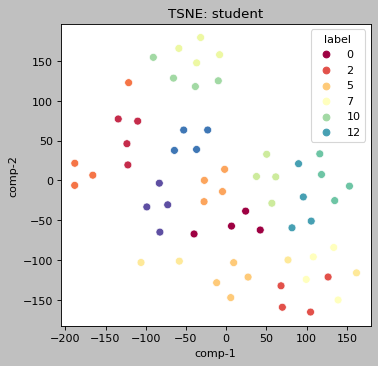

In [16]:
df["comp-1"] = X_tsne[:,0]
df["comp-2"] = X_tsne[:,1]


plt.figure(figsize = (5, 5), dpi = 80, facecolor = 'silver', edgecolor = 'gray')


sns.scatterplot(x = "comp-1", y = "comp-2", hue = "label", s = 50, palette = sns.color_palette("Spectral", as_cmap=True),
            data = df).set(title = "TSNE: {}".format(checkpoint_key))

plt.show()